# RNA-Ligand interactions

# setup

In [93]:
import pandas as pd
import json
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, Crippen
from functools import lru_cache
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

from rna_motif_library.plotting import publication_style_ax
from rna_motif_library.util import add_motif_name_columns

## extra functions

In [2]:
# SMARTS: ring-O connected to N
aminoglycoside_smarts = Chem.MolFromSmarts("[R][O][C,N][N]")


# Aminoglycoside functions
def is_aminoglycoside_like(smiles):
    if not isinstance(smiles, str) or not smiles.strip():
        return False

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False

    ring_info = mol.GetRingInfo()
    ring_atom_sets = ring_info.AtomRings()
    total_rings = len(ring_atom_sets)

    # Count non-aromatic rings
    aromatic_rings = 0
    for ring in ring_info.BondRings():
        if all(mol.GetBondWithIdx(b).GetIsAromatic() for b in ring):
            aromatic_rings += 1
    non_aromatic_rings = total_rings - aromatic_rings
    if non_aromatic_rings < 1:
        return False

    # Require at least 1 sp3 hybridized nitrogen
    sp3_nitrogens = sum(
        1
        for atom in mol.GetAtoms()
        if atom.GetSymbol() == "N"
        and atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3
    )
    if sp3_nitrogens < 1:
        return False

    # Check for oxygen-containing rings connected to sp2/sp3 nitrogen
    for ring in ring_atom_sets:
        ring_atoms = [mol.GetAtomWithIdx(i) for i in ring]
        if any(a.GetSymbol() == "O" for a in ring_atoms):
            for atom in ring_atoms:
                for neighbor in atom.GetNeighbors():
                    if neighbor.GetSymbol() == "N" and neighbor.GetHybridization() in (
                        Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3,
                    ):
                        return True
                    for nn in neighbor.GetNeighbors():
                        if nn.GetSymbol() == "N" and nn.GetHybridization() in (
                            Chem.rdchem.HybridizationType.SP2,
                            Chem.rdchem.HybridizationType.SP3,
                        ):
                            return True
    return False

In [3]:
# Riboswitch function
def check_riboswitch(row, pdb_title_lookup):
    # Combine all PDB codes from the three columns
    all_pdbs = set()
    for pdb_id in row["noncovalent_results"]:
        all_pdbs.add(pdb_id.lower())

    # Check if any matching PDB ID has "riboswitch" in its title
    for pdb_id in all_pdbs:
        title = pdb_title_lookup.get(pdb_id)
        if title and "riboswitch" in title:
            return True
    return False

In [4]:
def is_druglike_lipinski(row):
    smiles = row.get("smiles", "")
    if not isinstance(smiles, str) or not smiles.strip():
        return False

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False

    # Lipinski's Rule of Five Criteria
    mw = Descriptors.MolWt(mol)  # Molecular weight
    h_donors = Lipinski.NumHDonors(mol)  # H-bond donors
    h_acceptors = Lipinski.NumHAcceptors(mol)  # H-bond acceptors
    logp = Crippen.MolLogP(mol)  # Partition coefficient

    return h_donors <= 5 and h_acceptors <= 10 and mw < 500 and logp <= 5

In [5]:
df_ligand_info = pd.read_json("../data/ligands/summary/versions/v1/ligand_info.json")
df_ligand_instances = pd.read_json("../rna_ligand_interactions_w_duplicates.json")
df_ligand_w_motifs = pd.read_json("../rna_ligand_interactions_w_motifs.json")
df_pdb_title = pd.read_json("../pdb_titles.json")

In [6]:
pdb_title_lookup = {}
for i, row in df_pdb_title.iterrows():
    pdb_title_lookup[row["pdb_id"].lower()] = row["title"].lower()

In [20]:
df_ligand_instances = df_ligand_instances.query("duplicate == -1").copy()
df_ligand_instances["ligand_id"] = (
    df_ligand_instances["ligand_res"].str.split("-").str[1]
)

In [8]:
df_ligand_info["aminoglycoside"] = df_ligand_info["smiles"].apply(
    is_aminoglycoside_like
)
df_ligand_info["metabolite"] = df_ligand_info.apply(
    lambda row: check_riboswitch(row, pdb_title_lookup), axis=1
)
df_ligand_info["drug-like"] = df_ligand_info.apply(is_druglike_lipinski, axis=1)
df_ligand_info["classification"] = df_ligand_info.apply(
    lambda row: (
        "Aminoglycoside"
        if row["aminoglycoside"]
        else (
            "Metabolite"
            if row["metabolite"]
            else "Drug-like" if row["drug-like"] else "Other"
        )
    ),
    axis=1,
)

[10:44:17] Explicit valence for atom # 11 P, 6, is greater than permitted
[10:44:17] Explicit valence for atom # 0 B, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:44:17] Explicit valence for atom # 38 O, 3, is greater than permitted
[10:44:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 8 O, 2, is greater than permitted
[10:44:17] Explicit valence for atom # 13 N, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:44:17] Explicit valence for atom # 51 N, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 22 N, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 11 N, 4, is greater than permitted
[10:44:17] Explicit valence for atom # 15 P, 6, is greater than permitted
[10:44:17] Explicit valence for atom # 7 C, 

In [9]:
df_ligand_info.rename(columns={"id": "ligand_id"}, inplace=True)

In [22]:
# Merge classification from ligand_info to ligand_instances based on ligand_id
df_ligand_instances = df_ligand_instances.merge(
    df_ligand_info[["ligand_id", "classification"]], on="ligand_id", how="left"
)

In [23]:
df_ligand_instances["classification"].value_counts()

classification
Aminoglycoside    1060
Metabolite         495
Other              365
Drug-like          231
Name: count, dtype: int64

In [37]:
df_ligand_info.query("classification == 'Other' and type == 'LIGAND'")

,ligand_id,type,name,formula,formula_weight,smiles,has_phosphate,pdb_type,noncovalent_results,covalent_results,...,h_donors,aromatic_rings,rings,assigned_solvent,assigned_ligand,assigned_polymer,aminoglycoside,metabolite,drug-like,classification
34,GSH,LIGAND,GLUTATHIONE,C10 H17 N3 O6 S,307.323,C(CC(=O)NC(CS)C(=O)NCC(=O)O)C(C(=O)O)N,False,non-polymer,"[13GS, 19GS, 1AQW, 1B48, 1B4Q, 1DUG, 1F3A, 1FH...","[11GS, 1DNC, 1EEM, 1F2E, 1FLJ, 1GRA, 1GRE, 1GR...",...,NaN,NaN,NaN,False,True,False,False,False,False,Other
55,UTP,LIGAND,URIDINE 5'-TRIPHOSPHATE,C9 H15 N2 O15 P3,484.141,C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,False,non-polymer,"[1GX6, 1NB6, 1R8C, 1TWF, 1UEI, 1V34, 2B51, 2B5...","[1R9S, 7WJ4]",...,7.0,1.0,2.0,False,True,False,False,False,False,Other
109,2TM,LIGAND,5'-O-[(S)-hydroxy{[(S)-hydroxy(phosphonooxy)ph...,C10 H18 N3 O13 P3,481.184,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)(CP(=O)(O)O...,False,non-polymer,"[4OIO, 4Q4Z, 5X22, 6JUQ, 6JUR, 6JUS, 6P1T, 6P1...",[],...,7.0,1.0,2.0,False,True,False,False,False,False,Other
253,NPM,LIGAND,N-[(1E)-PYRIDIN-2-YLMETHYLENE]-N-[4-(4-{[(1E)-...,C25 H20 N4,376.453,c1ccnc(c1)C=Nc2ccc(cc2)Cc3ccc(cc3)N=Cc4ccccn4,False,non-polymer,[4JIY],[],...,0.0,4.0,4.0,False,True,False,False,False,False,Other
286,TAC,LIGAND,TETRACYCLINE,C22 H24 N2 O8,444.435,CC1(c2cccc(c2C(=O)C3=C(C4(C(CC31)C(C(=C(C4=O)C...,False,non-polymer,"[1HNW, 4V9A, 5J5B, 5J7L, 8CF1, 8CGJ]",[],...,6.0,1.0,4.0,False,True,False,False,False,False,Other
430,FB,LIGAND,5A-FORMYLBICYCLOMYCIN,C13 H18 N2 O8,330.291,CC(CO)(C(C12C(=O)NC(C(=CC=O)CCO1)(C(=O)N2)O)O)O,False,non-polymer,[1XPR],[],...,6.0,0.0,3.0,False,True,False,False,False,False,Other
436,8B4,LIGAND,"(1S)-1-(4-aminoimidazo[2,1-f][1,2,4]triazin-7-...",C11 H16 F N5 O9 P2,443.219,CC1(C(OC(C1O)COP(=O)(O)OP(=O)(O)O)c2cnc3n2ncnc...,False,non-polymer,[5UJ2],[],...,5.0,2.0,3.0,False,True,False,False,False,False,Other
915,84T,LIGAND,"[(2S,4S,5R)-5-(6-aminopurin-9-yl)-4-oxidanyl-o...",C16 H25 N6 O8 P,460.379,CC(C)C(C(C(=O)NP(=O)(O)OCC1CC(C(O1)n2cnc3c2ncn...,False,non-polymer,[3ZGZ],[],...,6.0,2.0,3.0,False,True,False,False,False,False,Other
957,G6P,LIGAND,6-O-phosphono-alpha-D-glucopyranose,C6 H13 O9 P,260.136,C(C1C(C(C(C(O1)O)O)O)O)OP(=O)(O)O,False,"D-saccharide, alpha linking","[2HO7, 2Z74, 3L3C]",[],...,6.0,0.0,1.0,False,True,False,False,False,False,Other
1121,SY5,LIGAND,"2-[[[(3~{R},5~{R})-3-azanyl-6-(3-azanylpropyla...",C12 H27 N5 O4,305.374,CN(CC(=O)O)NC(=O)CC(CC(CNCCCN)O)N,False,non-polymer,[7B5K],[],...,6.0,0.0,0.0,False,True,False,False,False,False,Other


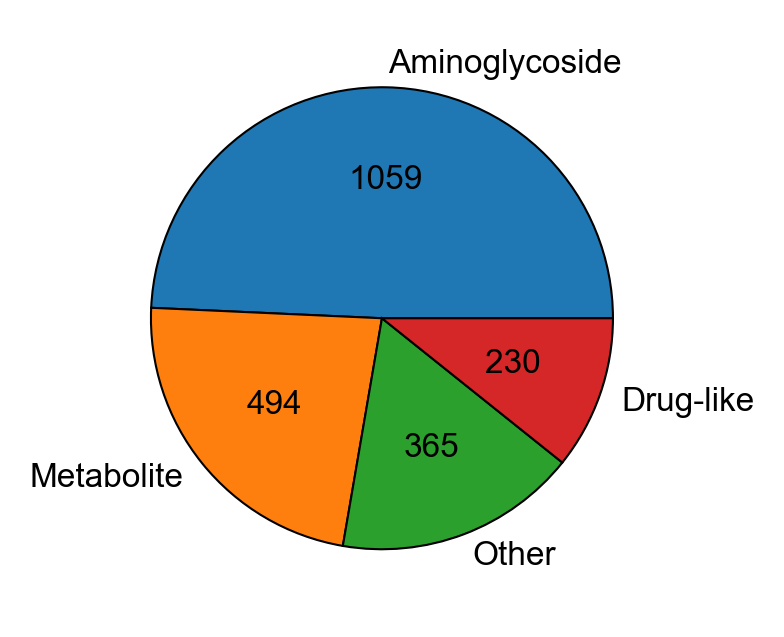

In [33]:
# Create a pie chart showing ligand classifications with actual numbers
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
classification_counts = df_ligand_instances["classification"].value_counts()
colors = sns.color_palette()
ax.pie(
    classification_counts,
    labels=classification_counts.index,
    autopct=lambda pct: f"{int(pct/100.*sum(classification_counts))}",
    wedgeprops={"edgecolor": "black", "linewidth": 0.5},
    colors=colors,
)
publication_style_ax(ax)

In [42]:
data = []
for i, row in df_ligand_instances.iterrows():
    for hbond in row["hbonds"]:
        data.append([hbond["atom_1"], row["classification"]])
df_hbonds = pd.DataFrame(data, columns=["atom", "classification"])

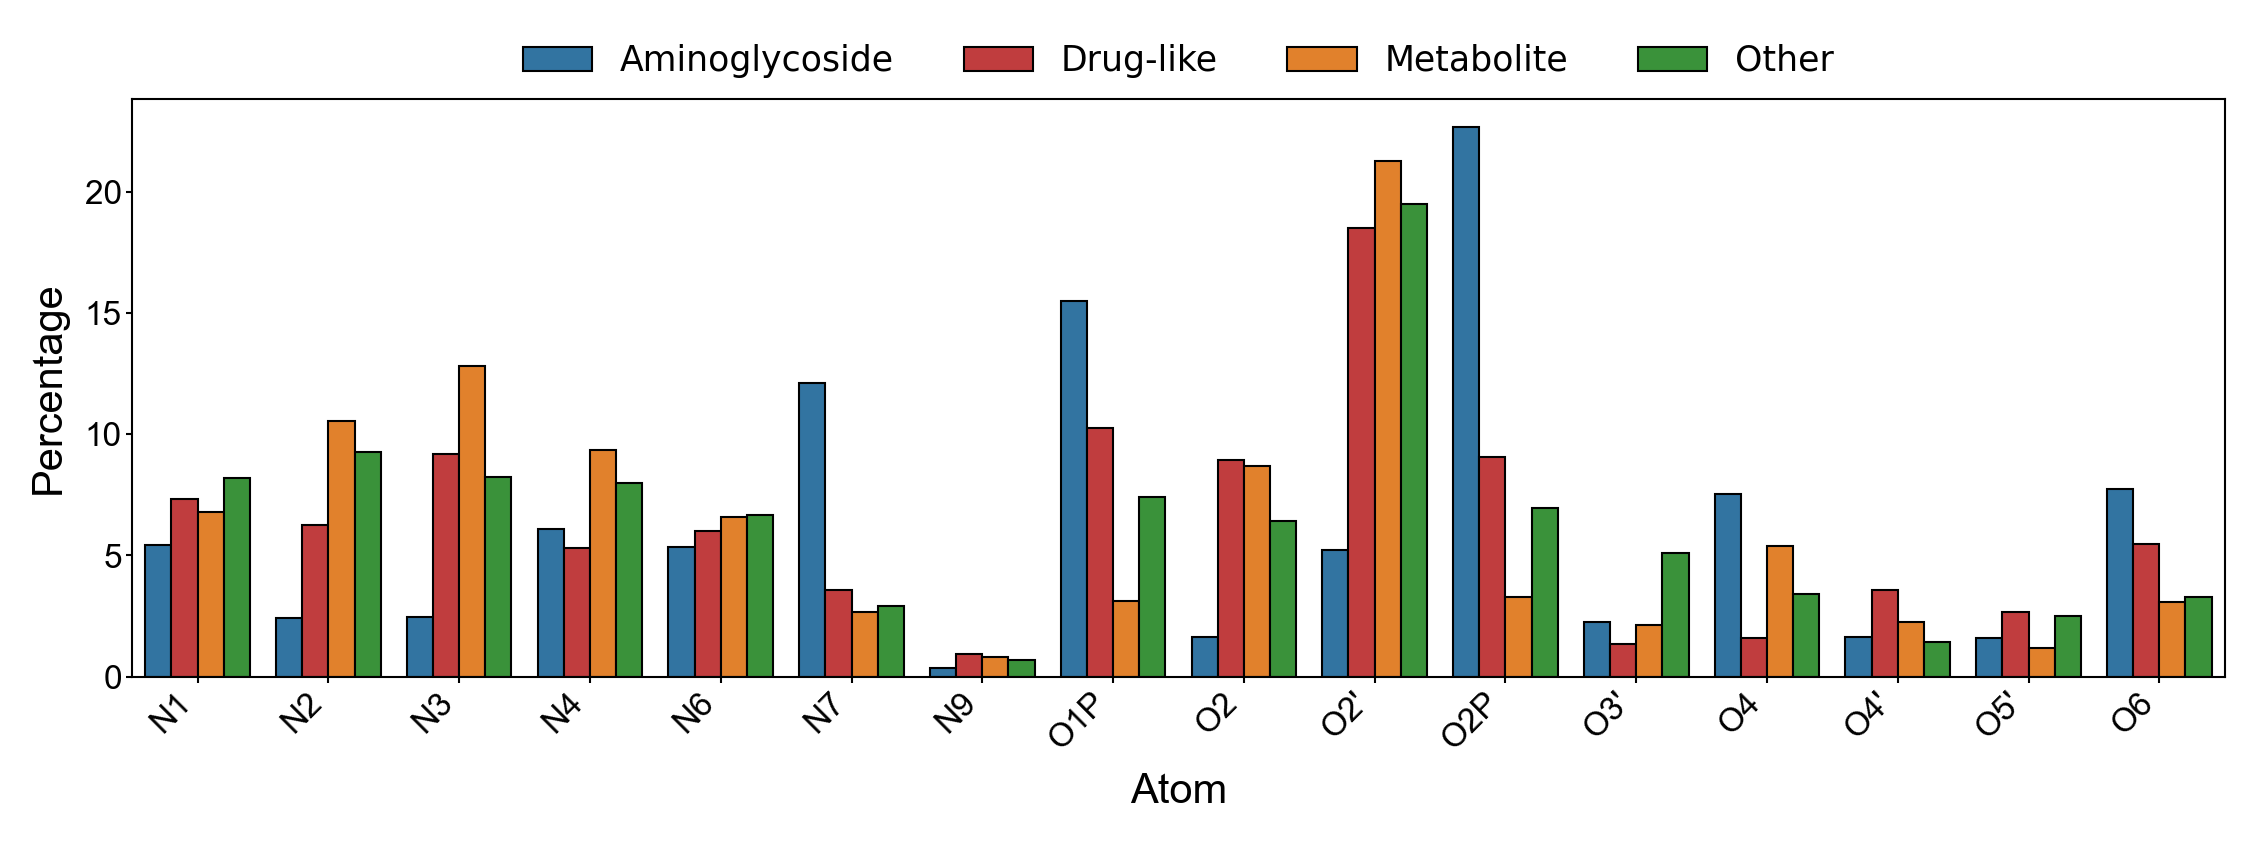

In [86]:
# Create normalized counts by classification
df_normalized = (
    df_hbonds[df_hbonds["atom"] != "O3P"]
    .groupby(["atom", "classification"])
    .size()
    .unstack(fill_value=0)
)
# Normalize by total counts per classification instead of per atom
classification_totals = (
    df_hbonds[df_hbonds["atom"] != "O3P"].groupby("classification").size()
)
df_normalized = df_normalized.div(classification_totals, axis=1) * 100

# Plot with seaborn
plt.figure(figsize=(9.0, 2.5), dpi=300)
ax = sns.barplot(
    data=df_normalized.reset_index().melt(id_vars="atom"),
    x="atom",
    y="value",
    hue="classification",
    palette={
        "Aminoglycoside": sns.color_palette()[0],
        "Metabolite": sns.color_palette()[1],
        "Drug-like": sns.color_palette()[3],
        "Other": sns.color_palette()[2],
    },
    edgecolor="black",  # Add black edges to bars
    linewidth=0.5,  # Set edge line width
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentage")
plt.xlabel("Atom")
ax.legend(
    bbox_to_anchor=(0.5, 1.15),
    loc="upper center",
    ncol=4,
    frameon=False,
    fontsize="small",
    markerscale=0.1,  # Make legend line indicators smaller
)  # Make legend text smaller
publication_style_ax(ax)

In [69]:
data = []
for i, row in df_ligand_instances.iterrows():
    data.append([len(row["hbonds"]), row["classification"]])
df_hbond_count = pd.DataFrame(data, columns=["num_hbonds", "classification"])

In [74]:
df_ligand_instances.iloc[0]

ligand_res                                                     A-2BA-204-
ligand_id                                                             2BA
interacting_residues    [A-G-26-, A-C-90-, A-C-43-, A-C-104-, A-G-25-,...
hbonds                  [{'res_1': 'A-G-26-', 'atom_1': 'O3'', 'atom_2...
num_hbonds                                                             17
hbond_score                                                     13.040242
pdb_id                                                               4QLM
duplicate                                                              -1
classification                                                 Metabolite
Name: 0, dtype: object

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_53050/1507437801.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


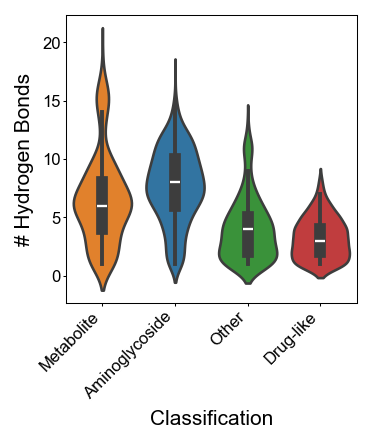

In [92]:
plt.figure(figsize=(2.5, 2.5), dpi=150)
ax = sns.violinplot(
    data=df_hbond_count,
    x="classification",
    y="num_hbonds",
    palette={
        "Aminoglycoside": sns.color_palette()[0],
        "Metabolite": sns.color_palette()[1],
        "Drug-like": sns.color_palette()[3],
        "Other": sns.color_palette()[2],
    },
    inner="box",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Classification")
plt.ylabel("# Hydrogen Bonds")
publication_style_ax(ax)

In [100]:
df_ligand_w_motifs["ligand_id"] = df_ligand_w_motifs["ligand_res"].str.split("-").str[1]
df_ligand_w_motifs = df_ligand_w_motifs.merge(
    df_ligand_info[["ligand_id", "classification"]], on="ligand_id", how="left"
)

In [101]:
df_ligand_w_motifs.iloc[0]

ligand_res                                                     A-2BA-204-
ligand_id                                                             2BA
interacting_residues    [A-G-26-, A-C-90-, A-C-43-, A-C-104-, A-G-25-,...
hbonds                  [{'res_1': 'A-G-26-', 'atom_1': 'O3'', 'atom_2...
num_hbonds                                                             17
hbond_score                                                     13.040242
pdb_id                                                               4QLM
duplicate                                                              -1
interacting_motifs      [HELIX-4-CCUC-GGGG-4QLM-1, HELIX-4-GCCC-GGGC-4...
num_motifs                                                              4
classification                                                 Metabolite
Name: 0, dtype: object

In [115]:
data = []
data_count = []
for i, row in df_ligand_w_motifs.iterrows():
    for m in row["interacting_motifs"]:
        data.append([m, row["classification"]])
        data_count.append([len(row["interacting_motifs"]), row["classification"]])
df_motifs = pd.DataFrame(data, columns=["motif_name", "classification"])
df_motifs_count = pd.DataFrame(data_count, columns=["num_motifs", "classification"])

In [104]:
df_motifs = add_motif_name_columns(df_motifs, "motif_name")

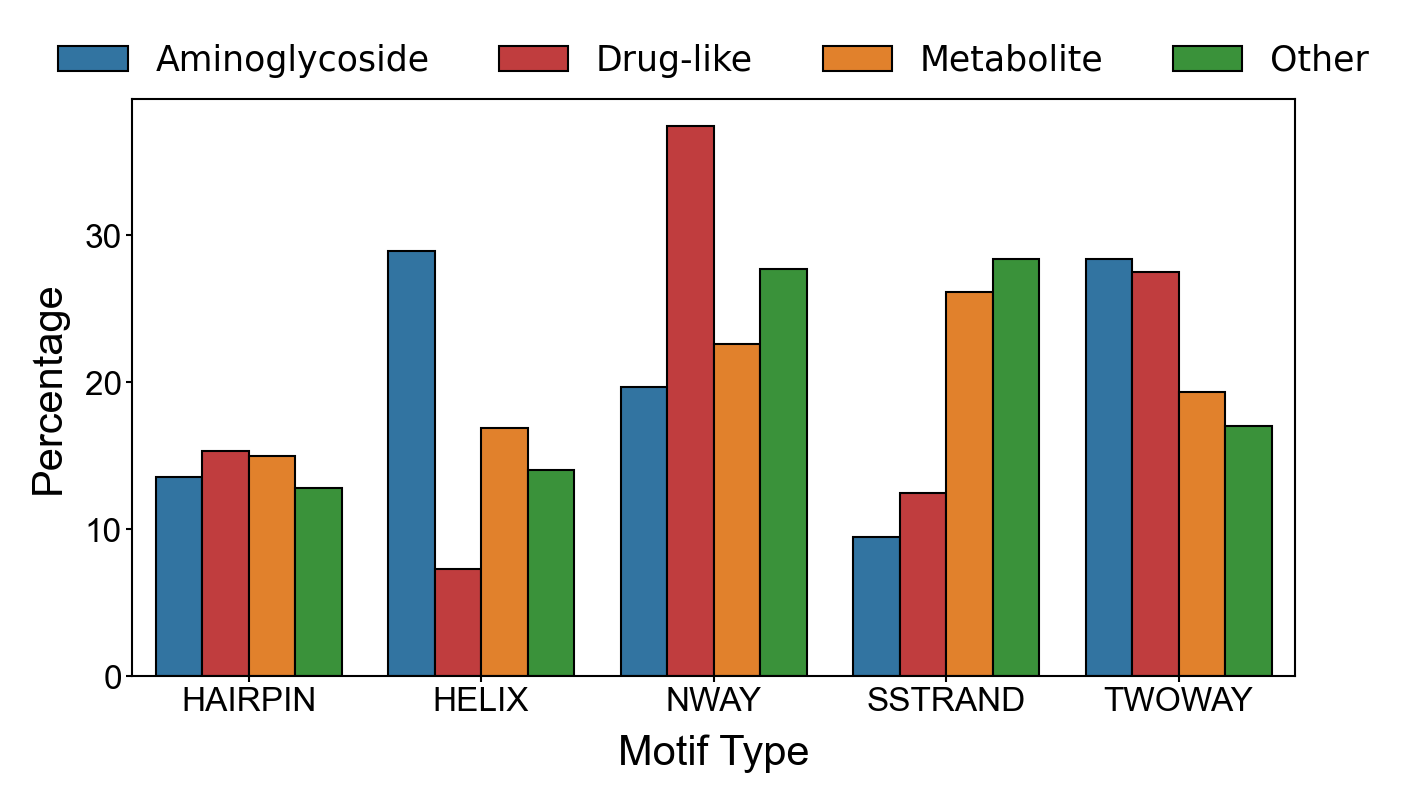

In [114]:
# Create normalized counts by classification
df_normalized = (
    df_motifs.groupby(["mtype", "classification"]).size().unstack(fill_value=0)
)
# Normalize by total counts per classification instead of per atom
classification_totals = df_motifs.groupby("classification").size()
df_normalized = df_normalized.div(classification_totals, axis=1) * 100

# Plot with seaborn
plt.figure(figsize=(5.0, 2.5), dpi=300)
ax = sns.barplot(
    data=df_normalized.reset_index().melt(id_vars="mtype"),
    x="mtype",
    y="value",
    hue="classification",
    palette={
        "Aminoglycoside": sns.color_palette()[0],
        "Metabolite": sns.color_palette()[1],
        "Drug-like": sns.color_palette()[3],
        "Other": sns.color_palette()[2],
    },
    edgecolor="black",  # Add black edges to bars
    linewidth=0.5,  # Set edge line width
)
plt.xticks(rotation=0, ha="center")
plt.ylabel("Percentage")
plt.xlabel("Motif Type")
ax.legend(
    bbox_to_anchor=(0.5, 1.15),
    loc="upper center",
    ncol=4,
    frameon=False,
    fontsize="small",
    markerscale=0.1,  # Make legend line indicators smaller
)  # Make legend text smaller
publication_style_ax(ax)

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_53050/821453304.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


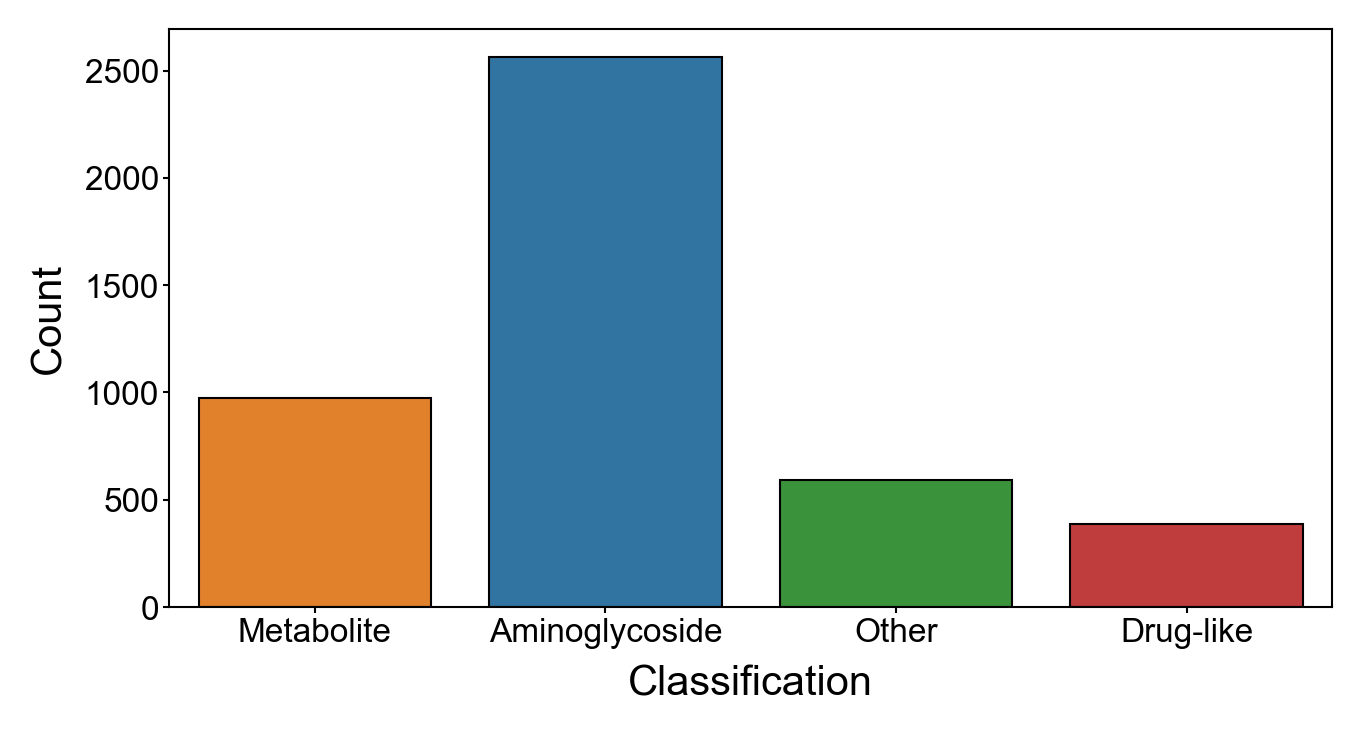

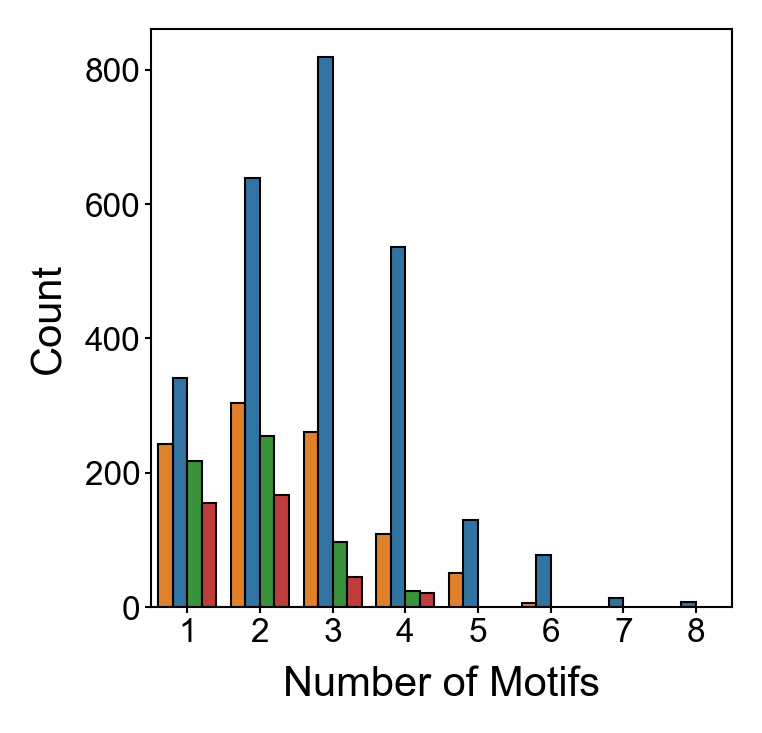

In [153]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
sns.countplot(
    df_motifs_count,
    x="num_motifs",
    hue="classification",
    palette={
        "Aminoglycoside": sns.color_palette()[0],
        "Metabolite": sns.color_palette()[1],
        "Drug-like": sns.color_palette()[3],
        "Other": sns.color_palette()[2],
    },
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    legend=False,
)
plt.ylabel("Count")
plt.xlabel("Number of Motifs")


publication_style_ax(ax)